In [1]:
!git clone https://github.com/cure-lab/LTSF-Linear.git

fatal: destination path 'LTSF-Linear' already exists and is not an empty directory.


### 데이터 로드하는 과정에서 encoding = 'cp949'로 입력되어있던 부분을 제거, temp 변수 불러오는데 header 지정되어있던 것을 삭제

In [1]:
import os
import sys
from tqdm import tqdm
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',family = 'Malgun Gothic')
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import warnings
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import tqdm
import re

from lightgbm import LGBMRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance



#### 외부데이터 출처 및 설명은 모델 설명서에 적어놨습니다

In [98]:

supply = pd.read_csv('Z:/team/월별공급량및비중.csv')

submission_sample = pd.read_csv('Z:/team/submission_sample.csv')

In [99]:
supply.head()

,YEAR,MONTH,도시가스(톤)_민수용,도시가스(톤)_산업용,도시가스(톤)_총합(민수용+산업용),민수용비중,산업용비중
0,1996,1,605519.0,83809.0,689328.0,0.87842,0.12158
1,1996,2,566323.0,70427.0,636750.0,0.88940,0.11060
2,1996,3,477514.0,62652.0,540166.0,0.88401,0.11599
3,1996,4,337794.0,47050.0,384844.0,0.87774,0.12226
4,1996,5,184522.0,30709.0,215231.0,0.85732,0.14268


In [100]:
target_minsu = pd.DataFrame({'date':pd.date_range(start='1996',end='2021',freq='M'),'target':supply['도시가스(톤)_민수용']})
target_sanup = pd.DataFrame({'date':pd.date_range(start='1996',end='2021',freq='M'),'target':supply['도시가스(톤)_총합(민수용+산업용)']})
target_sanup_real = pd.DataFrame({'date':pd.date_range(start='1996',end='2021',freq='M'),'target':supply['도시가스(톤)_산업용']})

In [101]:
target_minsu['date'] = target_minsu['date'].apply(lambda x: str(x)[:7])
target_sanup['date'] = target_sanup['date'].apply(lambda x: str(x)[:7])
target_sanup_real['date'] = target_sanup_real['date'].apply(lambda x: str(x)[:7])

In [102]:
target_minsu['date'] = pd.to_datetime(target_minsu['date'])
target_sanup['date'] = pd.to_datetime(target_minsu['date'])
target_sanup_real['date'] = pd.to_datetime(target_minsu['date'])

In [103]:
def make_target(dataset,target_col):
    dataset['date'] = dataset['YEAR'].astype(str)+dataset['MONTH'].astype(str)
    dataset['date'] = dataset['date'].apply(lambda x : x[:4]+'0'+x[4]+'01' if len(x)==5 else x+'01')
    dataset['date'] = pd.to_datetime(dataset['date'])
    return pd.concat([dataset[['date']],dataset[target_col]],axis=1)

## 외부데이터

In [104]:
features = pd.DataFrame({'date': pd.date_range(start ='1996', end = '2021', freq='M')})
features['date'] = features['date'].apply(lambda x: str(x)[:7])
features['date'] = pd.to_datetime(features['date'])

In [105]:
price = pd.read_csv('Z:/team/상업용 상대가격(기준=2015).csv')

In [106]:
price = make_target(price,price.columns[2:])

In [107]:
features = pd.merge(features,price,on='date')

In [108]:
GDP_GNI = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/GDP_GNI.csv')

In [109]:
GDP_GNI['date'] = GDP_GNI['시점'].apply(lambda x: x.split('.')[0] + '-' + str(int(x.split('.')[1][0])*3)).apply (lambda x: x[:5]+'0'+x[5] if len(x)==6 else x)

In [110]:
GDP_GNI.drop(['시점'],axis=1,inplace=True)

In [111]:
interpolate_data = pd.DataFrame({'date':pd.date_range(start='1996',end='2021',freq='M')})
interpolate_data = interpolate_data['date'].apply(lambda x: str(x)[:7])
GDP_GNI = pd.merge(interpolate_data,GDP_GNI,on='date',how='left')

In [112]:
GDP_GNI['date'] = pd.to_datetime(GDP_GNI['date'])
GDP_GNI.set_index('date',inplace=True)

In [113]:
GDP_GNI = GDP_GNI.interpolate(method='time')

In [114]:
features = pd.merge(features,GDP_GNI,on='date',how='left')

In [115]:
QVA = pd.read_csv('Z:/team/제조업 부가가치(분기별).csv')

In [116]:
QVA['date'] = QVA['YEAR'].astype(str)+QVA['QUARTER']
QVA['date'] = QVA['date'].apply(lambda x: x.split('Q')[0] + '-' + str(int(x.split('Q')[1])*3)).apply (lambda x: x[:5]+'0'+x[5] if len(x)==6 else x)

In [117]:
interpolate_data = pd.DataFrame({'date':pd.date_range(start='1996',end='2021',freq='M')})
interpolate_data = interpolate_data['date'].apply(lambda x: str(x)[:7])
QVA = pd.merge(interpolate_data,QVA[['date','QVA(제조업부가가치/단위:십억원)']],on='date',how='left')

In [118]:
QVA['date'] = pd.to_datetime(QVA['date'])
QVA = QVA.set_index('date')

In [119]:
QVA = QVA.interpolate(method='time')

In [120]:
QVA.reset_index(inplace=True)

In [121]:
features = pd.merge(features,QVA,on='date',how='left')

In [122]:
features.head()

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,국내총소득(GDI),국외순수취요소소득,국민총소득(GNI),QVA(제조업부가가치/단위:십억원)
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.60000,189912.800000,-527.500000,189472.300000,36550.300000
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.43587,195570.738043,-737.491304,194923.515217,36753.181522
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.66413,201046.161957,-940.708696,200198.884783,36949.518478


In [123]:
mulga = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/mulga.csv')

In [124]:
mulga = mulga.set_index('시도별').T.reset_index().rename(columns= {'index':'date'})

In [125]:
mulga['date'] = pd.to_datetime(mulga['date'])

In [126]:
features = pd.merge(features,mulga,on='date',how='left')

In [127]:
features.head()

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,국내총소득(GDI),국외순수취요소소득,국민총소득(GNI),QVA(제조업부가가치/단위:십억원),전국
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.289
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.499
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.60000,189912.800000,-527.500000,189472.300000,36550.300000,53.862
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.43587,195570.738043,-737.491304,194923.515217,36753.181522,54.226
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.66413,201046.161957,-940.708696,200198.884783,36949.518478,54.538


In [128]:
temp_effect = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/temp_effect.csv')

In [129]:
temp_effect = temp_effect.iloc[:,:2].dropna()
temp_effect['date'] = temp_effect['수도권 기온효과 날짜'].apply(lambda x: x[:7])
temp_effect.drop(['수도권 기온효과 날짜'],axis=1,inplace=True)

In [130]:
temp_effect['date'] = pd.to_datetime(temp_effect['date'])

In [131]:
features = pd.merge(features,temp_effect,on='date',how='left')

In [132]:
temp = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/temp.csv')

In [133]:
temp['date'] = temp['년월'].apply(lambda x: x.split('-')[0]+ '.' + x.split('-')[1])

In [134]:
temp['date'] = pd.to_datetime(temp['date'])

In [135]:
temp.drop(['년월'],axis=1,inplace=True)

In [136]:
features = pd.merge(features,temp, on ='date',how='left')

In [137]:
nanbang = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/nanbang.csv').set_index('분류별(1)').T

In [138]:
nanbang = nanbang.reset_index().rename(columns = {'index':'date'})

In [139]:
nanbang['date'] = pd.to_datetime(nanbang['date'])

In [140]:
features = pd.merge(features,nanbang, on = 'date', how='left')
features

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,...,QVA(제조업부가가치/단위:십억원),전국,수도권 기온효과,지점,평균기온(℃),최저기온(℃),최고기온(℃),평균기온 (℃),난방도일 (도일),냉방도일 (도일)
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,53.289,0.84711,108,-2.2,-10.7,9.8,NaN,NaN,NaN
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,53.499,0.81430,108,-1.6,-13.8,14.0,NaN,NaN,NaN
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.600000,...,36550.300000,53.862,0.60731,108,4.9,-3.8,17.5,NaN,NaN,NaN
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.435870,...,36753.181522,54.226,0.24132,108,10.2,-0.9,23.3,NaN,NaN,NaN
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.664130,...,36949.518478,54.538,-0.38328,108,18.4,9.8,31.4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-08-01,0.86,72.93,84.71,7787.515217,1327.013043,417325.692391,39369.967391,456755.884783,-5416.997826,...,118851.965217,100.190,-0.52038,108,26.5,21.5,34.5,26.5,0.0,78.1
296,2020-09-01,0.80,65.24,81.26,7569.100000,1254.500000,419561.500000,40330.900000,459981.300000,-5268.400000,...,121747.500000,100.740,-0.48046,108,21.4,13.6,29.5,21.4,0.0,2.9
297,2020-10-01,0.76,59.16,78.13,7251.924176,1585.983516,428078.664835,40192.174725,468325.321978,-5230.290110,...,122734.170330,100.180,-0.14824,108,14.3,3.2,23.6,14.3,118.9,0.0
298,2020-11-01,0.75,58.72,78.64,6924.175824,1928.516484,436879.735165,40048.825275,476947.478022,-5190.909890,...,123753.729670,100.090,0.23138,108,8.0,-3.6,20.0,8.0,299.2,0.0


In [141]:
ingu = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/ingu.csv')

In [142]:
ingu = ingu.drop(['가정별'],axis=1).set_index('인구구조,부양비별').T.reset_index().rename(columns = {'index':'date'})

In [143]:
ingu.head()

"인구구조,부양비별",date,총인구(명),남자(명),여자(명),성비(여자1백명당),인구성장률,인구(명): 0-14세,인구(명): 15-64세,인구(명): 65세 이상,- 구성비(%): 0-14세,...,총부양비,유소년부양비,노년부양비,노령화지수,중위연령(세),중위연령(세)-남자,중위연령(세)-여자,평균연령(세),평균연령(세)-남자,평균연령(세)-여자
0,1994,44641540.0,22472496.0,22169044.0,101.4,1.01,10653446.0,31445602.0,2542492.0,23.9,...,42.0,33.9,8.1,23.9,28.8,28.0,29.7,30.8,29.7,32.0
1,1995,45092991.0,22705329.0,22387662.0,101.4,1.01,10536828.0,31899511.0,2656652.0,23.4,...,41.4,33.0,8.3,25.2,29.3,28.4,30.2,31.2,30.1,32.3
2,1996,45524681.0,22924512.0,22600169.0,101.4,0.95,10403277.0,32326522.0,2794882.0,22.9,...,40.8,32.2,8.6,26.9,29.8,28.9,30.7,31.5,30.4,32.7
3,1997,45953580.0,23148092.0,22805488.0,101.5,0.94,10233102.0,32791167.0,2929311.0,22.3,...,40.1,31.2,8.9,28.6,30.3,29.4,31.2,31.9,30.8,33.1
4,1998,46286503.0,23295727.0,22990776.0,101.3,0.72,10091517.0,33125933.0,3069053.0,21.8,...,39.7,30.5,9.3,30.4,30.7,29.8,31.7,32.3,31.1,33.4


In [144]:
def only_year(x):
    data = pd.DataFrame({'date' : pd.date_range(start='1996',end='2021',freq = 'M')})
    data['date'] = data['date'].apply(lambda x: str(x)[:7])
    x['date'] = x['date'].apply(lambda x: str(x)+'-12')
    df = pd.merge(data,x,on='date',how='left')
    return df

In [145]:
ingu = only_year(ingu)

In [146]:
ingu['date'] = pd.to_datetime(ingu['date'])

In [147]:
ingu.set_index('date',inplace=True)

In [148]:
ingu = ingu.interpolate(method='time').reset_index()

In [149]:
features = pd.merge(features,ingu,on='date',how='left')

In [150]:
features

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,...,총부양비,유소년부양비,노년부양비,노령화지수,중위연령(세),중위연령(세)-남자,중위연령(세)-여자,평균연령(세),평균연령(세)-남자,평균연령(세)-여자
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.435870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.664130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-08-01,0.86,72.93,84.71,7787.515217,1327.013043,417325.692391,39369.967391,456755.884783,-5416.997826,...,38.333333,16.966667,21.333333,125.933333,43.50000,42.10000,44.90000,42.533333,41.333333,43.733333
296,2020-09-01,0.80,65.24,81.26,7569.100000,1254.500000,419561.500000,40330.900000,459981.300000,-5268.400000,...,38.426503,16.949727,21.451913,126.788798,43.55082,42.15082,44.95082,42.575683,41.375683,43.775683
297,2020-10-01,0.76,59.16,78.13,7251.924176,1585.983516,428078.664835,40192.174725,468325.321978,-5230.290110,...,38.516667,16.933333,21.566667,127.616667,43.60000,42.20000,45.00000,42.616667,41.416667,43.816667
298,2020-11-01,0.75,58.72,78.64,6924.175824,1928.516484,436879.735165,40048.825275,476947.478022,-5190.909890,...,38.609836,16.916393,21.685246,128.472131,43.65082,42.25082,45.05082,42.659016,41.459016,43.859016


In [151]:
TDR = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/TDR.csv')

In [152]:
TDR.rename(columns = {'연도':'date'},inplace=True)

In [153]:
TDR = only_year(TDR)

In [154]:
TDR['date'] = pd.to_datetime(TDR['date'])
TDR.set_index('date',inplace=True)

In [155]:
TDR = TDR.interpolate(method='time').reset_index()

In [156]:
features = pd.merge(features,TDR,on='date',how='left')
features

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,...,주택용,산업용,일반용,열병합용,수송용,직공급,업무난방용,냉방용,도시가스 통합,발전용
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.435870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.664130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-08-01,0.86,72.93,84.71,7787.515217,1327.013043,417325.692391,39369.967391,456755.884783,-5416.997826,...,8.433333,1.80000,2.033333,5.966667,1.4,1.333333,8.90000,6.433333,3.166667,2.50000
296,2020-09-01,0.80,65.24,81.26,7569.100000,1254.500000,419561.500000,40330.900000,459981.300000,-5268.400000,...,8.246995,1.82541,2.024863,5.746448,1.4,1.324863,8.82377,6.602732,3.175137,2.57623
297,2020-10-01,0.76,59.16,78.13,7251.924176,1585.983516,428078.664835,40192.174725,468325.321978,-5230.290110,...,8.066667,1.85000,2.016667,5.533333,1.4,1.316667,8.75000,6.766667,3.183333,2.65000
298,2020-11-01,0.75,58.72,78.64,6924.175824,1928.516484,436879.735165,40048.825275,476947.478022,-5190.909890,...,7.880328,1.87541,2.008197,5.313115,1.4,1.308197,8.67377,6.936066,3.191803,2.72623


In [157]:
pop = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/pop.csv')

In [158]:
pop = pop.drop(['가정별'],axis=1).query('성별=="전체"').drop(['성별'],axis=1).set_index('연령별').T.loc['1996':,:'80세이상'].reset_index().rename(columns = {'index':'date'})

In [159]:
pop = pop.astype(int)

In [160]:
def only_year(x,sy='1996',ey='2021'):
    data = pd.DataFrame({'date':pd.date_range(start = sy, end = ey, freq='M')})
    data['date'] = data['date'].apply(lambda x:str(x)[:7])
    x['date'] = x['date'].apply(lambda x: str(x)+'-12')
    df = pd.merge(data,x,on='date',how='left')
    return df

In [161]:
pop = only_year(pop,'1996','2035')

In [162]:
pop.set_index('date',inplace=True)

In [163]:
pop = pop.interpolate().reset_index()

In [164]:
pop['date'] = pd.to_datetime(pop['date'])

In [165]:
features = pd.merge(features,pop[:300],on='date',how='left')

In [166]:
features

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,...,35 - 39세,40 - 44세,45 - 49세,50 - 54세,55 - 59세,60 - 64세,65 - 69세,70 - 74세,75 - 79세,80세이상
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.435870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.664130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-08-01,0.86,72.93,84.71,7787.515217,1327.013043,417325.692391,39369.967391,456755.884783,-5416.997826,...,3.928576e+06,3864067.0,4.419695e+06,4.324809e+06,4256509.0,3.752230e+06,2.591029e+06,1955600.00,1.602188e+06,1.848760e+06
296,2020-09-01,0.80,65.24,81.26,7569.100000,1254.500000,419561.500000,40330.900000,459981.300000,-5268.400000,...,3.913176e+06,3866093.0,4.411204e+06,4.328174e+06,4251648.5,3.767765e+06,2.608830e+06,1964286.75,1.603757e+06,1.859276e+06
297,2020-10-01,0.76,59.16,78.13,7251.924176,1585.983516,428078.664835,40192.174725,468325.321978,-5230.290110,...,3.897777e+06,3868119.0,4.402714e+06,4.331539e+06,4246788.0,3.783300e+06,2.626630e+06,1972973.50,1.605326e+06,1.869792e+06
298,2020-11-01,0.75,58.72,78.64,6924.175824,1928.516484,436879.735165,40048.825275,476947.478022,-5190.909890,...,3.882378e+06,3870145.0,4.394223e+06,4.334904e+06,4241927.5,3.798835e+06,2.644431e+06,1981660.25,1.606895e+06,1.880308e+06


#### 월별 기온민감도

In [167]:
mingam = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/mingam.csv')

In [168]:
mingamdo = mingam.transpose()
mingamdo = mingamdo.reset_index().rename(columns = {'index' : 'month'})
mingamdo.month[1:] = mingamdo.index[1:]

mingamdo.loc[0][1:] = [-4,-3,-2,-1,0,1,2,3,4]
mingamdo.head()

,month,0,1,2,3,4,5,6,7,8
0,구분,-4,-3,-2,-1,0,1,2,3,4
1,1,124.23,118.83,113.34,107.8,100.0,96.84,91.84,87.4,83.18
2,2,123.01,117.48,112.04,106.72,100.0,96.48,91.75,87.26,82.91
3,3,115.57,115.57,110.91,106.06,100.0,95.72,90.06,84.03,77.44
4,4,115.07,115.07,110.31,106.28,100.0,95.49,90.16,90.16,90.16


In [169]:
feat_te = features.copy()
temp_col = feat_te['평균기온(℃)']
feat_te['month'] = features.date.dt.month
feat_te.groupby('month')['평균기온(℃)'].mean()

feat_te = pd.merge(feat_te,feat_te.groupby('month')['평균기온(℃)'].mean(),how = 'left', on = 'month')
feat_te.rename(columns = {'평균기온(℃)_y':'월별_평균기온'},inplace = True)

feat_te['평균기온_차이'] = np.clip(feat_te[['평균기온(℃)_x','월별_평균기온']].apply(lambda x : round(x[0] - x[1],),axis = 1),-4,4)

temp_idx = feat_te[['month','평균기온_차이']].values

feat_te.평균기온_차이.value_counts()
res = []
for i in temp_idx:
    m = i[0]
    j = i[1] +4
    res.append(mingamdo.query('month == @m')[j].values[0])
    
feat_te['기온민감도'] = pd.Series(res)
feat_te

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,...,55 - 59세,60 - 64세,65 - 69세,70 - 74세,75 - 79세,80세이상,month,월별_평균기온,평균기온_차이,기온민감도
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,-2.052,0,100.00
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,0.688,-2,112.04
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,3,6.184,-1,106.06
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.435870,...,NaN,NaN,NaN,NaN,NaN,NaN,4,12.604,-2,110.31
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.664130,...,NaN,NaN,NaN,NaN,NaN,NaN,5,18.416,0,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-08-01,0.86,72.93,84.71,7787.515217,1327.013043,417325.692391,39369.967391,456755.884783,-5416.997826,...,4256509.0,3.752230e+06,2.591029e+06,1955600.00,1.602188e+06,1.848760e+06,8,26.220,0,100.00
296,2020-09-01,0.80,65.24,81.26,7569.100000,1254.500000,419561.500000,40330.900000,459981.300000,-5268.400000,...,4251648.5,3.767765e+06,2.608830e+06,1964286.75,1.603757e+06,1.859276e+06,9,21.812,0,100.00
297,2020-10-01,0.76,59.16,78.13,7251.924176,1585.983516,428078.664835,40192.174725,468325.321978,-5230.290110,...,4246788.0,3.783300e+06,2.626630e+06,1972973.50,1.605326e+06,1.869792e+06,10,15.180,-1,108.08
298,2020-11-01,0.75,58.72,78.64,6924.175824,1928.516484,436879.735165,40048.825275,476947.478022,-5190.909890,...,4241927.5,3.798835e+06,2.644431e+06,1981660.25,1.606895e+06,1.880308e+06,11,7.500,0,100.00


In [170]:
features = pd.merge(features,feat_te[['date','기온민감도']],how= 'left',on ='date')
features.head()

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,...,40 - 44세,45 - 49세,50 - 54세,55 - 59세,60 - 64세,65 - 69세,70 - 74세,75 - 79세,80세이상,기온민감도
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.04
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.60000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.06
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.43587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.31
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.66413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00


In [171]:
features.columns

Index(['date', 'RP(상대가격)', 'GAS_PRICE(산업용도시가스)', 'OIL_PRICE(원유정제처리제품)', '전기업',
       '가스 증기 및 공기조절 공급업', '총부가가치(기초가격)', '순생산물세', '국내총생산(시장가격 GDP)',
       '교역조건 변화를 반영한 실질무역손익', '국내총소득(GDI)', '국외순수취요소소득', '국민총소득(GNI)',
       'QVA(제조업부가가치/단위:십억원)', '전국', '수도권 기온효과', '지점', '평균기온(℃)', '최저기온(℃)',
       '최고기온(℃)', '평균기온 (℃)', '난방도일 (도일)', '냉방도일 (도일)', '총인구(명)', '남자(명)',
       '여자(명)', '성비(여자1백명당)', '인구성장률', '인구(명): 0-14세', '인구(명): 15-64세',
       '인구(명): 65세 이상', '- 구성비(%): 0-14세', '- 구성비(%): 15-64세',
       '- 구성비(%): 65세 이상', '총부양비', '유소년부양비', '노년부양비', '노령화지수', '중위연령(세)',
       '중위연령(세)-남자', '중위연령(세)-여자', '평균연령(세)', '평균연령(세)-남자', '평균연령(세)-여자',
       '주택용', '산업용', '일반용', '열병합용', '수송용', '직공급', '업무난방용', '냉방용', '도시가스 통합',
       '발전용', '계', '0 - 4세', '5 - 9세', '10 - 14세', '15 - 19세', '20 - 24세',
       '25 - 29세', '30 - 34세', '35 - 39세', '40 - 44세', '45 - 49세', '50 - 54세',
       '55 - 59세', '60 - 64세', '65 - 69세', '70 - 74세', '75 - 79세', '80세이상',
       '기온민감도'],
      dtype='object')

### 기온반응도

In [172]:
baneung = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/baneung.csv')

In [173]:
baneung

,기온,수도권 순수 기온반응도,수도권 시간 기온반응도,지방권 순수 기온반응도,지방권 시간 기온반응도,수도권 기온반응도,동남권 기온반응도,대경권 기온반응도,충청권 기온반응도,호남권 기온반응도
0,-20.0,1.11644,-0.02022,-1.71844,1.81408,0.14650,0.77177,0.45639,0.49034,0.58850
1,-19.9,1.11092,-0.01769,-1.69904,1.80363,0.14988,0.76866,0.45420,0.48900,0.58655
2,-19.8,1.10550,-0.01520,-1.67966,1.79313,0.15322,0.76553,0.45201,0.48766,0.58458
3,-19.7,1.10017,-0.01275,-1.66029,1.78261,0.15652,0.76240,0.44982,0.48632,0.58260
4,-19.6,1.09494,-0.01034,-1.64095,1.77205,0.15978,0.75925,0.44762,0.48496,0.58061
...,...,...,...,...,...,...,...,...,...,...
596,39.6,-0.59786,1.07482,0.14728,-0.69271,-0.52486,-0.57572,-0.37512,-0.38403,-0.38980
597,39.7,-0.58742,1.07751,0.15451,-0.70302,-0.53009,-0.57880,-0.37729,-0.38534,-0.39171
598,39.8,-0.57688,1.08016,0.16172,-0.71337,-0.53537,-0.58188,-0.37946,-0.38666,-0.39364
599,39.9,-0.56625,1.08277,0.16892,-0.72375,-0.54069,-0.58497,-0.38164,-0.38799,-0.39558


In [174]:
features = pd.merge(features,baneung,how ='left', left_on = "평균기온(℃)",right_on = "기온");features.head()

,date,RP(상대가격),GAS_PRICE(산업용도시가스),OIL_PRICE(원유정제처리제품),전기업,가스 증기 및 공기조절 공급업,총부가가치(기초가격),순생산물세,국내총생산(시장가격 GDP),교역조건 변화를 반영한 실질무역손익,...,기온,수도권 순수 기온반응도,수도권 시간 기온반응도,지방권 순수 기온반응도,지방권 시간 기온반응도,수도권 기온반응도,동남권 기온반응도,대경권 기온반응도,충청권 기온반응도,호남권 기온반응도
0,1996-01-01,0.97,26.94,27.86,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.2,0.90974,-0.10172,0.60570,0.07052,0.19784,0.17268,0.08867,0.17631,0.14445
1,1996-02-01,0.93,26.94,29.04,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.6,0.90110,-0.11392,0.62305,0.03742,0.18682,0.15522,0.07960,0.16425,0.12949
2,1996-03-01,0.96,26.94,27.99,2277.900000,1363.300000,154077.400000,15356.800000,169643.100000,20269.60000,...,4.9,0.67719,-0.21152,0.55229,-0.15283,0.06211,-0.00474,0.00200,0.03760,-0.01369
3,1996-04-01,0.94,26.94,28.74,2315.672826,1223.698913,158359.578261,15967.634783,174538.269565,21032.43587,...,10.2,0.30955,-0.20085,0.24070,-0.10996,-0.02166,-0.09498,-0.03763,-0.05387,-0.09846
4,1996-05-01,0.92,26.94,29.18,2352.227174,1088.601087,162503.621739,16558.765217,179275.530435,21770.66413,...,18.4,-0.43937,0.03287,-0.31749,0.10353,-0.09319,-0.18713,-0.08322,-0.16527,-0.17645


In [175]:
features['month'] = features['date'].dt.month
features['year'] = features['date'].dt.year

In [176]:
def season(x):
    if x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'autumn'
    else:
        return 'winter'

In [177]:
features = pd.concat([features,pd.get_dummies(features['month'].apply(season))],axis=1)

In [178]:
# 중복 컬럼 제거
features = features.drop(columns = ['평균기온 (℃)','지점','업무난방용'])

In [179]:
features = features.dropna().reset_index(drop=True)

In [180]:
data = pd.read_csv('Z:/검증용제출물_11월25일_17시까지/외부데이터/data.csv').set_index('분류별(1)').T
data = data.reset_index().rename(columns = {'index':'date'})

In [181]:
data.석유 = data.석유.apply(lambda x : str(x).replace(",","")).astype(int)
data.석탄 = data.석탄.apply(lambda x : str(x).replace(",","")).astype(int)
data.전력 = data.전력.apply(lambda x : str(x).replace(",","")).astype(int)
data.열 = data.열.apply(lambda x : str(x).replace(",","")).astype(int)
data.도시가스 = data.도시가스.apply(lambda x : str(x).replace(",","")).astype(int)
data.천연가스 = data.천연가스.apply(lambda x : str(x).replace(",","")).astype(int)
data.합계 = data.합계.apply(lambda x : str(x).replace(",","")).astype(int)
data['신재생 및 기타'] = data['신재생 및 기타'].apply(lambda x : str(x).replace(",","")).astype(int)

In [182]:
data.date = pd.to_datetime(data.date)

In [183]:
features = pd.merge(features,data,on = 'date')

In [184]:
## 12월과 1월의 연결을 위해 삼각함수 사용
features['cos_month'] = np.cos(2 * np.pi * features['month']/11.0)

In [185]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 0 to 286
Data columns (total 95 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 287 non-null    datetime64[ns]
 1   RP(상대가격)             287 non-null    float64       
 2   GAS_PRICE(산업용도시가스)   287 non-null    float64       
 3   OIL_PRICE(원유정제처리제품)  287 non-null    float64       
 4   전기업                  287 non-null    float64       
 5   가스 증기 및 공기조절 공급업     287 non-null    float64       
 6   총부가가치(기초가격)          287 non-null    float64       
 7   순생산물세                287 non-null    float64       
 8   국내총생산(시장가격 GDP)      287 non-null    float64       
 9   교역조건 변화를 반영한 실질무역손익  287 non-null    float64       
 10  국내총소득(GDI)           287 non-null    float64       
 11  국외순수취요소소득            287 non-null    float64       
 12  국민총소득(GNI)           287 non-null    float64       
 13  QVA(제조업부가가치/단위:십억원)  287 non-null  

In [186]:
total_minsu = pd.merge(features,target_minsu,on='date',how='inner')
total_sanup = pd.merge(features,target_sanup,on='date',how='inner')

# DeepLearning(DLinear)

In [187]:
sys.path.append('/LTSF_Linear') #시계열 예측 모델 사용을 위한 path추가

In [188]:
from LTSF_Linear.utils.tools import EarlyStopping, adjust_learning_rate, visual, test_params_flop
from LTSF_Linear.utils.metrics import metric # 사용 모듈 import

In [189]:
# custom dataset 적용을 위한 class 생성
class Dataset_Custom(Dataset):
    def __init__ (self,flag ='train', features='S', dataset = target_minsu, size=None,target='OT',freq='m',inverse=True,scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        
        assert flag in ['train','test','val','pred']
        type_map = {'train': 0, 'val': 1, 'test': 2, 'pred':3}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.freq = freq
        self.data= dataset
        self.inverse=inverse
        
        self.__read_data__()
        
    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.data

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        # print(cols)
        if self.set_type !=3:
            num_train = int(len(df_raw) * 0.7)
            num_test = int(len(df_raw) * 0.3)
            num_vali = len(df_raw) - num_train - num_test
            border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
            border2s = [num_train, num_train + num_vali, len(df_raw)]
            border1 = border1s[self.set_type]
            border2 = border2s[self.set_type]
        else:
            border1 = len(df_raw) - self.seq_len
            border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            if self.set_type != 3:
                train_data = df_data[border1s[0]:border2s[0]]
                self.scaler.fit(train_data.values)
                data = self.scaler.transform(df_data.values)
            else:
                self.scaler.fit(df_data.values)
                data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
        
        if self.set_type==3:
            tmp_stamp = df_raw[['date']][border1:border2]
            tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
            
            pred_dates = pd.date_range(tmp_stamp.date.values[-1],periods = self.pred_len +1, freq=self.freq)
            
            df_stamp = pd.DataFrame(columns=['date'])
            df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        else:
            df_stamp = df_raw[['date']][border1:border2]
            df_stamp['date'] = pd.to_datetime(df_stamp.date)
            
        df_stamp['year'] = df_stamp.date.apply(lambda row: row.year, 1)
        df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
        data_stamp = df_stamp.drop(['date'], 1).values

        self.data_x = data[border1:border2]
        if self.inverse & self.set_type ==3:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        
        seq_x = self.data_x[s_begin:s_end]
        if self.set_type == 3:
            if self.inverse:
                seq_y = self.data_x[r_begin:r_begin + self.label_len]
            else:
                seq_y = self.data_y[r_begin:r_begin + self.label_len]
        else:
            seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        if self.set_type !=3:
            return len(self.data_x) - self.seq_len - self.pred_len + 1
        else:
            return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)
    

In [190]:
# 이동평균 생성 class
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

In [191]:
# Series decomposition block
class series_decomp(nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

In [192]:
class Model(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self):
        super(Model, self).__init__()
        self.seq_len = size[0]
        self.pred_len = size[1]

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = False
        self.channels = 7

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [ ]:
# target 예측 후 저장을 위한 데이터프레임 생성
def targeting(x):
    new_target = pd.DataFrame({'date':pd.date_range(target_minsu.date.values[24],periods = 444,freq='m'),'target':np.zeros(444)})
    new_target.loc[:276,'target'] = x
    train_target = new_target[:276]
    return train_target, new_target

In [ ]:
# 다음 10개의 변수들을 y값 예측을 위한 변수로 미래 데이터 생성
# 10개 변수 선택 이유는 아래에서 설명
#iloc[11:,:] 이유는 1997년 데이터 1월을 못가져와서 1998년부터 데이터 사용하기 위함
X1 = features.iloc[11:,:]['QVA(제조업부가가치/단위:십억원)'].reset_index(drop = True)
X2 = features.iloc[11:,:]['GAS_PRICE(산업용도시가스)'].reset_index(drop = True)
X3 = features.iloc[11:,:]['평균기온(℃)'].reset_index(drop = True)
X4 = features.iloc[11:,:]['주택용'].reset_index(drop = True)
X5 = features.iloc[11:,:]['일반용'].reset_index(drop = True)
X6 = features.iloc[11:,:]['전력'].reset_index(drop = True)
X7 = features.iloc[11:,:]['열'].reset_index(drop = True)
X8 = features.iloc[11:,:]['난방도일 (도일)'].reset_index(drop = True)
X9 = features.iloc[11:,:]['전기업'].reset_index(drop = True)
X10 = features.iloc[11:,:]['수도권 기온효과'].reset_index(drop = True)

In [ ]:
X1, new_target1 = targeting(X1)   # targeting함수 적용
X2, new_target2 = targeting(X2)
X3, new_target3 = targeting(X3)
X4, new_target4 = targeting(X4)
X5, new_target5 = targeting(X5)
X6, new_target6 = targeting(X6)
X7, new_target7 = targeting(X7)
X8, new_target8 = targeting(X8)
X9, new_target9 = targeting(X9)
X10, new_target10 = targeting(X10)

In [ ]:
trt_minsu, new_target_minsu = targeting(target_minsu.iloc[:276,1])

In [ ]:
batch_size=12     # 다음과같이 지정
shuffle_flag =True
num_workers=0
drop_last = True

size=[12*2,12,12]   # 24개월로 12개월 예측하겠다고 지정

In [ ]:
# dataloader
minsu_train_dataset = Dataset_Custom(flag='train',features='S',dataset= trt_minsu,size=size,target='target',scale=True,freq='m',inverse=True)
minsu_train_loader = DataLoader(minsu_train_dataset,batch_size=batch_size,shuffle=True, num_workers = num_workers, drop_last=drop_last)
minsu_test_dataset = Dataset_Custom(flag='test',features='S',dataset= trt_minsu,size=size,target='target',scale=True,freq='m',inverse=True)
minsu_test_loader = DataLoader(minsu_test_dataset,batch_size=batch_size,shuffle=False, num_workers = num_workers, drop_last=drop_last)

In [ ]:
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):   # batch_process
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0],size[2],batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:size[1],:],dec_inp],dim=1).float().to(device)
    outputs = model(batch_x).to(device)
    outputs = outputs[:,-size[2]:,0:]
    batch_y = batch_y[:,-size[2]:,0:].to(device)
    return outputs, batch_y

In [ ]:
print(torch.cuda.is_available())
device=torch.device("cuda:0")

In [ ]:
pred_year = 168   # 예측 column수
pred_len = size[2]   # 예측 data 넣어주고
for feature_n ,t,nt in zip(range(10),[X1,X2,X3,X4,X5,X6,X7,X8,X9,X10],[new_target1,new_target2,new_target3,new_target4,new_target5,new_target6,new_target7,new_target8,new_target9,new_target10]):
    for n in range(int(pred_year/pred_len)): 
        new_trt = nt.iloc[:276+pred_len*(n)]
        train_dataset = Dataset_Custom(flag='train',features='S',dataset= new_trt,size=size,target='target',scale=True,freq='m',inverse=True)
        train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers = num_workers, drop_last=drop_last)
        test_dataset = Dataset_Custom(flag='test',features='S',dataset= new_trt,size=size,target='target',scale=True,freq='m',inverse=True)
        test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False, num_workers = num_workers, drop_last=drop_last)
        
        model = Model().float().to(device)
        model.train()
        
        train_epochs = 100
        
        early_stopping = EarlyStopping(patience=10,verbose=True)
        
        model_optim = optim.Adam(model.parameters(),lr=0.001)
        criterion = nn.MSELoss()
        
        progress = tqdm(range(train_epochs))
        train_steps = len(train_loader)
        os.mkdir(f'Z:\검증용제출물_11월25일_17시까지/model_check/{feature_n}_{n}')
        for epoch in progress:
            epoch_time = time.time()
            train_loss = []
            for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
                model.train()
                model_optim.zero_grad()
                pred,true = _process_one_batch(batch_x,batch_y,batch_x_mark,batch_y_mark)
                loss = criterion(pred,true)
                train_loss.append(loss.item())
                loss.backward()
                model_optim.step()
            train_loss = np.average(train_loss)
            progress.set_description('loss: {:0.6f}'.format(train_loss))
            
            test_loss=[]
            for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
                model.eval()
                pred,true =_process_one_batch(batch_x,batch_y,batch_x_mark,batch_y_mark)
                loss = criterion(pred,true)
                test_loss.append(loss.item())
            test_loss = np.average(test_loss)
            progress.set_description("test_loss: {:0.6f}".format(test_loss))
            
            print("Epoch: {} cost time: {}".format(epoch+1,time.time() - epoch_time))
            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f}  Test Loss: {3:.7f}".format(
                epoch + 1, train_steps, train_loss,  test_loss))
            early_stopping(test_loss, model, path=f'Z:\검증용제출물_11월25일_17시까지/model_check/{feature_n}_{n}')
            if early_stopping.early_stop:
                print("Early stopping")
                break
            
        best_model_path = f'Z:\검증용제출물_11월25일_17시까지/model_check/{feature_n}_{n}/'+f'checkpoint.pth'
        model.load_state_dict(torch.load(best_model_path))
            
        model.eval()
        
        print(str(2020+n*2)+'~' +str(2020+(n+1)*2))
        train_target = nt[:276+pred_len*n]
        pred_dataset = Dataset_Custom(flag='pred',features='S',dataset= new_trt,size=size,target='target',scale=True,freq='m',inverse=True)
        pred_loader = DataLoader(pred_dataset,batch_size=batch_size,shuffle=False, num_workers = num_workers, drop_last=False)
        
        preds=[]
        
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
            
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            
            outputs = model(batch_x).to(device)
            preds = outputs.detach().cpu().numpy()
        
        nt.iloc[276+pred_len*n:276+pred_len*(n+1),1] = Dataset_Custom.inverse_transform(pred_dataset,preds[0])
        print(str(276+pred_len*n),str(276+pred_len*(n+1)))

In [ ]:
#예측된 columns 저장
new_target1.to_csv('target1.csv') 
new_target2.to_csv('target2.csv')
new_target3.to_csv('target3.csv')
new_target4.to_csv('target4.csv')
new_target5.to_csv('target5.csv')
new_target6.to_csv('target6.csv')
new_target7.to_csv('target7.csv')
new_target8.to_csv('target8.csv')
new_target9.to_csv('target9.csv')
new_target10.to_csv('target10.csv')

### target값을 모델로 예측

위 순서와 동일한 과정으로 Y값을 예측해서 결과를 낸다

In [193]:
# Y값을 모델로 예측
def targeting(x):
    new_target = pd.DataFrame({'date':pd.date_range(target_minsu.date.values[0],periods = 468,freq='m'),'target':np.zeros(468)})
    new_target.loc[:300,'target'] = x
    train_target = new_target[:300]
    return train_target, new_target

In [194]:
Y1 = target_minsu.target
Y2 = target_sanup_real.target

In [195]:
Y1, new_target1 = targeting(Y1)
Y2, new_target2 = targeting(Y2)

In [196]:
trt_minsu, new_target_minsu = targeting(target_minsu.iloc[:300,1])

In [197]:
# 다 동일하지만 예측 범위를 줄여서 12개월로 6개월 예측하게 변경(실험적 변경)
batch_size=12
shuffle_flag =True
num_workers=0
drop_last = True

size=[6*2,6,6] 

In [198]:
minsu_train_dataset = Dataset_Custom(flag='train',features='S',dataset= trt_minsu,size=size,target='target',scale=True,freq='m',inverse=True)
minsu_train_loader = DataLoader(minsu_train_dataset,batch_size=batch_size,shuffle=True, num_workers = num_workers, drop_last=drop_last)
minsu_test_dataset = Dataset_Custom(flag='test',features='S',dataset= trt_minsu,size=size,target='target',scale=True,freq='m',inverse=True)
minsu_test_loader = DataLoader(minsu_test_dataset,batch_size=batch_size,shuffle=False, num_workers = num_workers, drop_last=drop_last)

C:\Users\kogas\AppData\Local\Temp\2\ipykernel_6564\601254694.py:76: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_stamp = df_stamp.drop(['date'], 1).values
C:\Users\kogas\AppData\Local\Temp\2\ipykernel_6564\601254694.py:76: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_stamp = df_stamp.drop(['date'], 1).values


In [199]:
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0],size[2],batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:size[1],:],dec_inp],dim=1).float().to(device)
    outputs = model(batch_x).to(device)
    outputs = outputs[:,-size[2]:,0:]
    batch_y = batch_y[:,-size[2]:,0:].to(device)
    return outputs, batch_y

In [ ]:
pred_year = 168
pred_len = size[2]
for feature_n ,t,nt in zip(range(2),[Y1,Y2],[new_target1,new_target2]):
    for n in range(int(pred_year/pred_len)):
        new_trt = nt.iloc[:300+pred_len*(n)]
        train_dataset = Dataset_Custom(flag='train',features='S',dataset= new_trt,size=size,target='target',scale=True,freq='m',inverse=True)
        train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers = num_workers, drop_last=drop_last)
        test_dataset = Dataset_Custom(flag='test',features='S',dataset= new_trt,size=size,target='target',scale=True,freq='m',inverse=True)
        test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False, num_workers = num_workers, drop_last=drop_last)
        
        model = Model().float().to(device)
        model.train()
        
        train_epochs = 100
        
        early_stopping = EarlyStopping(patience=10,verbose=True)
        
        model_optim = optim.Adam(model.parameters(),lr=0.001)
        criterion = nn.MSELoss()
        
        progress = tqdm(range(train_epochs))
        train_steps = len(train_loader)
        os.mkdir(f'Z:\검증용제출물_11월25일_17시까지/model_check/Y{feature_n}_{n}')
        for epoch in progress:
            epoch_time = time.time()
            train_loss = []
            for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
                model.train()
                model_optim.zero_grad()
                pred,true = _process_one_batch(batch_x,batch_y,batch_x_mark,batch_y_mark)
                loss = criterion(pred,true)
                train_loss.append(loss.item())
                loss.backward()
                model_optim.step()
            train_loss = np.average(train_loss)
            progress.set_description('loss: {:0.6f}'.format(train_loss))
            
            test_loss=[]
            for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
                model.eval()
                pred,true =_process_one_batch(batch_x,batch_y,batch_x_mark,batch_y_mark)
                loss = criterion(pred,true)
                test_loss.append(loss.item())
            test_loss = np.average(test_loss)
            progress.set_description("test_loss: {:0.6f}".format(test_loss))
            
            print("Epoch: {} cost time: {}".format(epoch+1,time.time() - epoch_time))
            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f}  Test Loss: {3:.7f}".format(
                epoch + 1, train_steps, train_loss,  test_loss))
            early_stopping(test_loss, model, path=f'Z:\검증용제출물_11월25일_17시까지/model_check/Y{feature_n}_{n}')
            if early_stopping.early_stop:
                print("Early stopping")
                break
            
        best_model_path = f'Z:\검증용제출물_11월25일_17시까지/model_check/Y{feature_n}_{n}/'+f'checkpoint.pth'
        model.load_state_dict(torch.load(best_model_path))
            
        model.eval()
        
        print(str(2020+n*2)+'~' +str(2020+(n+1)*2))
        train_target = nt[:300+pred_len*n]
        pred_dataset = Dataset_Custom(flag='pred',features='S',dataset= new_trt,size=size,target='target',scale=True,freq='m',inverse=True)
        pred_loader = DataLoader(pred_dataset,batch_size=batch_size,shuffle=False, num_workers = num_workers, drop_last=False)
        
        preds=[]
        
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
            
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            
            outputs = model(batch_x).to(device)
            preds = outputs.detach().cpu().numpy()
        
        nt.iloc[300+pred_len*n:300+pred_len*(n+1),1] = Dataset_Custom.inverse_transform(pred_dataset,preds[0])
        print(str(300+pred_len*n),str(300+pred_len*(n+1)))

In [2]:
import pandas as pd

In [8]:
pd.read_csv('target1.csv').target[-168:].reset_index(drop = True)

0      127171.640625
1      129059.156250
2      126109.500000
3      125224.632812
4      128124.757812
           ...      
163    177572.812500
164    178437.125000
165    178954.109375
166    178814.906250
167    179783.796875
Name: target, Length: 168, dtype: float64

In [ ]:
submission_sample = pd.read_csv('Z:/team/submission_sample.csv')   ## 잘못 입력한 부분 수정
submission_sample['IND'] = new_target2.target[-168:].reset_index(drop = True)
submission_sample['CIVIL'] = new_target1.target[-168:].reset_index(drop = True)
submission_sample.to_csv('1266_submission.csv')

## Modeling Machine Learning

In [93]:
# 1998년도부터 2020년까지만 학습용으로 선택.

y_minsu = total_minsu.loc[11:,['target']] # 98년도부터 20년까지
y_sanup = total_sanup.loc[11:,['target']] # 98년도부터 20년까지
X_minsu = total_minsu.iloc[11:,1:-1] #98년도부터 20년까지 , date와 target값은 뺌
X_sanup = total_sanup.iloc[11:,1:-1] # 98년도부터, date와 target 값은 뺌

In [94]:
# 온도에 관련된 컬럼명을 변경하는 과정
X_minsu = X_minsu.rename(columns = {'평균기온 (℃)':'평균기온','최저기온(℃)':'최저기온','최고기온(℃)':'최고기온'})
X_sanup = X_sanup.rename(columns = {'평균기온 (℃)':'평균기온','최저기온(℃)':'최저기온','최고기온(℃)':'최고기온'})

In [96]:
# 성능 좋은 Feature 조합 및 회귀식을 찾기 위해서 각각의 전체 학습 데이터에서 마지막 2년치 (2019,2020)를 Test로 분할
X_minsu_train = X_minsu[:-24]
X_minsu_test = X_minsu[-24:]
X_sanup_train = X_sanup[:-24]
X_sanup_test = X_sanup[-24:]

In [97]:
# 정답값(Target)들도 마찬가지로 마지막 2년치(2019,2020)를 Test로 분할
y_minsu_train = y_minsu[:-24]
y_minsu_test = y_minsu[-24:]
y_sanup_train = y_sanup[:-24]
y_sanup_test = y_sanup[-24:]

In [98]:
y_minsu_prediction=[]
y_sanup_prediction=[]

# Feature selection with Statsmodels

#### 민수용 변수 선택

In [99]:
# 전체 X 변수들을 다항회귀에 적합시키기 위한 필요 라이브러리들을 불러옴.
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

In [100]:
# sm_minsu_data라는 변수명에 기존의 민수용 학습 데이터를 복사해 다항 회귀를 위한 DataFrame 생성
sm_minsu_data = X_minsu_train
sm_minsu_data['target'] = y_minsu_train

C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\2561284360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_minsu_data['target'] = y_minsu_train


In [101]:
# 다항회귀에 적합하기 위해서는 변수명이 한글로 되어있으면 안되므로 target을 제외한 나머지 변수명들을 'a숫자'로 변경.
num = 0
for i in sm_minsu_data.drop(['target'],axis = 1).columns:
    sm_minsu_data.rename(columns = {f'{i}':f"a{num}"},inplace = True)
    num+=1

C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\3678672551.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_minsu_data.rename(columns = {f'{i}':f"a{num}"},inplace = True)
C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\3678672551.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_minsu_data.rename(columns = {f'{i}':f"a{num}"},inplace = True)
C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\3678672551.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [102]:
# 다항회귀에 적합할 Formula 생성과정으로 target을 제외한 하나의 문자열 형식임.
column = ""
for i in sm_minsu_data.iloc[:,:-1].columns:
    column += i + '+'
column[:-1]

'a0+a1+a2+a3+a4+a5+a6+a7+a8+a9+a10+a11+a12+a13+a14+a15+a16+a17+a18+a19+a20+a21+a22+a23+a24+a25+a26+a27+a28+a29+a30+a31+a32+a33+a34+a35+a36+a37+a38+a39+a40+a41+a42+a43+a44+a45+a46+a47+a48+a49+a50+a51+a52+a53+a54+a55+a56+a57+a58+a59+a60+a61+a62+a63+a64+a65+a66+a67+a68+a69+a70+a71+a72+a73+a74+a75+a76+a77+a78+a79+a80+a81+a82+a83+a84+a85+a86+a87+a88+a89+a90+a91+a92+a93+a94'

In [103]:
# 원 변수 95개를 모두 회귀식에 적합

model_full = smf.ols(f'target ~ {column[:-1]}',data = sm_minsu_data).fit()
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1087.
Date:                Fri, 25 Nov 2022   Prob (F-statistic):          4.95e-198
Time:                        03:58:48   Log-Likelihood:                -2889.4
No. Observations:                 252   AIC:                             5945.
Df Residuals:                     169   BIC:                             6238.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.763e+06   2.36e+07     -0.117      0.907   -4.94e+07    4.38e+07
a0         -1.658e+05   1.04e+05     -1.602      0.111    -3.7e+05    3.85e+04
a1          2629.6859   1370.465      1.919      0.057     -75.750    5335.122
a2          -876.3813    750.285     -1.168      0.244   -2357.519     604.756
a3            -4.1651     14.274     -0.292      0.771     -32.344      24.013
a4            13.6603     22.537      0.606      0.545     -30.830      58.150
a5           -49.0690    134.075     -0.366      0.715    -313.747     215.609
a6           -63.1651    138.833     -0.455      0.650    -337.235     210.905
a7           6.53e+04   7.56e+04      0.864      0.389   -8.39e+04    2.14e+05
a8          6.525e+04   7.55e+04      0.864      0.389   -8.38e+04    2.14e+05
a9         -6.524e+04   7.55e+04     -0.864      0.389   -2.14e+05    8.39e+04
a10            9.6077    171.776      0.056      0.955    -329.495     348.710
a11           -7.1099    174.825     -0.041      0.968    -352.231     338.012
a12           -5.9454      3.567     -1.667      0.097     -12.987       1.096
a13        -2.526e+04   1.05e+04     -2.406      0.017    -4.6e+04   -4535.877
a14         8883.5846   6.75e+04      0.132      0.895   -1.24e+05    1.42e+05
a15        -6.115e+06   1.95e+07     -0.314      0.754   -4.46e+07    3.24e+07
a16         -744.2773   1355.403     -0.549      0.584   -3419.980    1931.425
a17          757.4475   1488.252      0.509      0.611   -2180.512    3695.407
a18          718.1567    296.408      2.423      0.016     133.018    1303.296
a19          258.8545    589.437      0.439      0.661    -904.753    1422.462
a20        -8.715e+04   2.11e+05     -0.413      0.680   -5.04e+05    3.29e+05
a21         1.397e+04   2.09e+05      0.067      0.947   -3.98e+05    4.26e+05
a22         1.256e+04   1.93e+05      0.065      0.948   -3.68e+05    3.93e+05
a23        -1.476e+08   1.49e+09     -0.099      0.921    -3.1e+09     2.8e+09
a24         1.013e+07   1.05e+08      0.097      0.923   -1.96e+08    2.17e+08
a25         7.375e+04   6.67e+04      1.106      0.270   -5.79e+04    2.05e+05
a26         7.396e+04   6.68e+04      1.108      0.270   -5.78e+04    2.06e+05
a27         7.363e+04   6.62e+04      1.113      0.267    -5.7e+04    2.04e+05
a28        -2.213e+07   1.83e+08     -0.121      0.904   -3.84e+08    3.39e+08
a29        -1.985e+08    1.5e+09     -0.132      0.895   -3.16e+09    2.76e+09
a30        -3.893e+07   6.95e+07     -0.560      0.576   -1.76e+08    9.83e+07
a31         -3.67e+07   1.88e+08     -0.195      0.845   -4.07e+08    3.34e+08
a32        -5.708e+06   4.32e+08     -0.013      0.989   -8.59e+08    8.48e+08
a33         1.269e+07    2.8e+08      0.045      0.964   -5.41e+08    5.66e+08
a34         3.211e+06   8.12e+07      0.040      0.969   -1.57e+08    1.64e+08
a3

In [105]:
# 위 결과에 따라 P-value 값이 낮은 것들을 우선적으로 선택
print(X_minsu.columns[1])
print(X_minsu.columns[7])
print(X_minsu.columns[8])
print(X_minsu.columns[9])
print(X_minsu.columns[12])
print(X_minsu.columns[13])
print(X_minsu.columns[14])
print(X_minsu.columns[16])
print(X_minsu.columns[18])
print(X_minsu.columns[19])
print(X_minsu.columns[41])
print(X_minsu.columns[50])
print(X_minsu.columns[75])
print(X_minsu.columns[76])
print(X_minsu.columns[77])

GAS_PRICE(산업용도시가스)
국내총생산(시장가격 GDP)
교역조건 변화를 반영한 실질무역손익
국내총소득(GDI)
QVA(제조업부가가치/단위:십억원)
전국
수도권 기온효과
최저기온
난방도일 (도일)
냉방도일 (도일)
주택용
계
동남권 기온반응도
대경권 기온반응도
충청권 기온반응도


In [191]:
# 최종적으로 민수용을 학습시키기 위한 변수를 선택하여 데이터프레임형태로 생성.
selec_data = X_minsu[['QVA(제조업부가가치/단위:십억원)','GAS_PRICE(산업용도시가스)'
                     ,'평균기온(℃)','주택용', '일반용','계','수도권 기온반응도','cos_month', '전력', '열']]

In [192]:
# 위와 마찬가지로 한글로 되어있는 변수들을 'a숫자'로 변경
num = 0
for i in selec_data.columns:
    selec_data.rename(columns = {f'{i}':f"a{num}"},inplace = True)
    num+=1

C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\3531151851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selec_data.rename(columns = {f'{i}':f"a{num}"},inplace = True)
C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\3531151851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selec_data.rename(columns = {f'{i}':f"a{num}"},inplace = True)
C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\3531151851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [193]:
# 다항회귀식의 mse값을 살펴보기 위해 위와 마찬가지로 Test를 마지막 2년치로 선택하고 진행
X_train = selec_data[:-24]
X_test = selec_data[-24:]
sm_train =X_train
sm_train['target'] = y_minsu_train

C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\1828027681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_train['target'] = y_minsu_train


In [194]:
# 다항회귀 적합식을 생성하기 위한 Formula 생성 과정
column = ""
for i in X_train.iloc[:,:-1].columns:
    column += i + '+'
column[:-1]

'a0+a1+a2+a3+a4+a5+a6+a7+a8+a9'

In [195]:
# 선택된 변수들만 다항회귀식에 적합
model = smf.ols(f'target ~ {column[:-1]}',data = sm_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2358.
Date:                Fri, 25 Nov 2022   Prob (F-statistic):          3.81e-234
Time:                        04:54:25   Log-Likelihood:                -3100.7
No. Observations:                 252   AIC:                             6223.
Df Residuals:                     241   BIC:                             6262.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    5.29e+06    7.9e+05      6.700      0.000    3.73e+06    6.85e+06
a0            -2.3452      1.399     -1.677      0.095      -5.101       0.410
a1           286.9198    272.295      1.054      0.293    -249.462     823.302
a2         -1.374e+04   2140.424     -6.417      0.000    -1.8e+04   -9519.173
a3         -7328.0607   4303.599     -1.703      0.090   -1.58e+04    1149.411
a4         -2.734e+04   3116.068     -8.775      0.000   -3.35e+04   -2.12e+04
a5            -0.1064      0.018     -5.974      0.000      -0.141      -0.071
a6          9.324e+05   1.71e+05      5.463      0.000    5.96e+05    1.27e+06
a7         -3.291e+04   6113.804     -5.382      0.000   -4.49e+04   -2.09e+04
a8           340.1067     39.433      8.625      0.000     262.429     417.785
a9          2226.4787    145.445     15.308      0.000    1939.974    2512.984
==============================================================================
Omnibus:                        4.091   Durbin-Watson:                   0.762
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                3.754
Skew:                           0.253   Prob(JB):                        0.153
Kurtosis:                       3.319   Cond. No.                     1.13e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1942266819.8505604

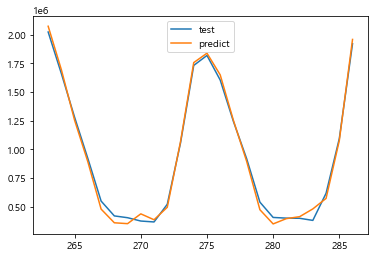

In [196]:
# 차이점을 그래프로 대강 확인하는 과정.
plt.plot(y_minsu_test)
plt.plot(model.predict(X_test))
plt.legend(['test','predict'])

from sklearn.metrics import mean_squared_error
mean_squared_error(y_minsu_test,model.predict(X_test))

#### 산업용(민수용 + 산업용, 즉 total) 변수 선택

In [197]:
sm_sanup_data = X_sanup_train
sm_sanup_data['target'] = y_sanup_train

num = 0
for i in sm_sanup_data.drop(['target'],axis = 1).columns:
    sm_sanup_data.rename(columns = {f'{i}':f"a{num}"},inplace = True)
    num+=1
column = ""
for i in sm_sanup_data.iloc[:,:-1].columns:
    column += i + '+'
column[:-1]

model_sanup_full = smf.ols(f'target ~ {column[:-1]}',data = sm_sanup_data).fit()
model_sanup_full.summary()

C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\2846169776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_sanup_data['target'] = y_sanup_train
C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\2846169776.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_sanup_data.rename(columns = {f'{i}':f"a{num}"},inplace = True)
C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\2846169776.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1425.
Date:                Fri, 25 Nov 2022   Prob (F-statistic):          6.23e-208
Time:                        04:57:30   Log-Likelihood:                -2911.2
No. Observations:                 252   AIC:                             5988.
Df Residuals:                     169   BIC:                             6281.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.063e+07   2.57e+07     -0.801      0.424   -7.15e+07    3.02e+07
a0          -1.38e+05   1.13e+05     -1.223      0.223   -3.61e+05    8.48e+04
a1          2127.4367   1494.420      1.424      0.156    -822.698    5077.571
a2          -204.9510    818.146     -0.251      0.802   -1820.052    1410.150
a3           -24.3803     15.565     -1.566      0.119     -55.107       6.347
a4           -19.7106     24.575     -0.802      0.424     -68.225      28.803
a5           -36.7813    146.202     -0.252      0.802    -325.399     251.836
a6           -35.5304    151.390     -0.235      0.815    -334.390     263.329
a7         -3.134e+04   8.24e+04     -0.380      0.704   -1.94e+05    1.31e+05
a8         -3.138e+04   8.24e+04     -0.381      0.704   -1.94e+05    1.31e+05
a9           3.15e+04   8.24e+04      0.382      0.703   -1.31e+05    1.94e+05
a10          113.5340    187.312      0.606      0.545    -256.239     483.307
a11         -114.1076    190.637     -0.599      0.550    -490.444     262.229
a12           -0.4464      3.889     -0.115      0.909      -8.125       7.232
a13        -3.129e+04   1.14e+04     -2.733      0.007   -5.39e+04   -8686.439
a14        -1.715e+05   7.36e+04     -2.328      0.021   -3.17e+05   -2.61e+04
a15        -1.537e+06   2.12e+07     -0.072      0.942   -4.35e+07    4.04e+07
a16         -414.8403   1477.995     -0.281      0.779   -3332.552    2502.871
a17          924.0242   1622.860      0.569      0.570   -2279.665    4127.713
a18          536.4170    323.217      1.660      0.099    -101.646    1174.480
a19          114.0065    642.749      0.177      0.859   -1154.845    1382.858
a20        -2.314e+05    2.3e+05     -1.006      0.316   -6.85e+05    2.23e+05
a21         1.975e+05   2.27e+05      0.868      0.386   -2.51e+05    6.46e+05
a22         1.837e+05    2.1e+05      0.874      0.383   -2.31e+05    5.99e+05
a23         -1.28e+09   1.63e+09     -0.786      0.433    -4.5e+09    1.94e+09
a24        -6.408e+07   1.14e+08     -0.562      0.575   -2.89e+08    1.61e+08
a25         4.086e+04   7.27e+04      0.562      0.575   -1.03e+05    1.84e+05
a26         4.136e+04   7.28e+04      0.568      0.571   -1.02e+05    1.85e+05
a27         3.737e+04   7.21e+04      0.518      0.605   -1.05e+05     1.8e+05
a28        -1.516e+08      2e+08     -0.759      0.449   -5.46e+08    2.43e+08
a29         -1.33e+09   1.63e+09     -0.814      0.417   -4.56e+09     1.9e+09
a30         -9.07e+07   7.58e+07     -1.197      0.233    -2.4e+08    5.89e+07
a31        -1.876e+08   2.05e+08     -0.916      0.361   -5.92e+08    2.17e+08
a32        -3.391e+08   4.71e+08     -0.719      0.473   -1.27e+09    5.92e+08
a33         2.293e+08   3.06e+08      0.750      0.455   -3.75e+08    8.33e+08
a34         6.308e+07   8.85e+07      0.712      0.477   -1.12e+08    2.38e+08
a3

In [203]:
# 위 결과를 보고 마찬가지로 p값이 낮은 것들 위주로 추출하니 misnu용 피처에 난방도일 , 전기업, 수도권 기온효과 추가로 삽입.
# 최종적으로 산업용(총합) 피처는 13개

"""
민수용 select된 것
['QVA(제조업부가가치/단위:십억원)','GAS_PRICE(산업용도시가스)'
,'평균기온(℃)','주택용', '일반용','계','수도권 기온반응도','cos_month', '전력', '열'] 
"""
    
print(['난방도일 (도일)','전기업','수도권 기온효과'])

['난방도일 (도일)', '전기업', '수도권 기온효과']


-------

#### Feature engineering -> 기준 model = lgbm

In [121]:
# LGBM모델링을 위해 기존 학습 데이터프레임을 새로운 변수에 복사
lgbm_minsu = X_minsu.copy()
lgbm_sanup = X_sanup.copy()
 
# lgbm 변수명 오류 발생 제거 위해 column명 변경
lgbm_minsu.columns = [i for i in range(len(lgbm_minsu.columns))]
lgbm_sanup.columns = [i for i in range(len(lgbm_sanup.columns))]

In [122]:
# 모델링의 성능을 테스트해보기 위해 마지막 2년치(2019,2020)을 test 셋으로 정의하고 실험 진행
lgbm_minsu_train = lgbm_minsu[:-24]
lgbm_minsu_test = lgbm_minsu[-24:]
lgbm_sanup_train = lgbm_sanup[:-24]
lgbm_sanup_test = lgbm_sanup[-24:]

In [123]:
# 필요 라이브러리 import
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold

In [124]:
# SelectFromModel 사용하여 피처 selection

all_features_train_fs = lgbm_minsu_train
all_features_test_fs = lgbm_minsu_test

lgbm_model = LGBMRegressor(random_state=0)
smf = SelectFromModel(lgbm_model,threshold = '2.0*mean')
smf.fit(all_features_train_fs,y_minsu_train)

X_new = smf.transform(all_features_train_fs)
X_te_new = smf.transform(all_features_test_fs)

feature_selection_idx = smf.get_support()
feature_selection_name = all_features_train_fs.columns[feature_selection_idx]

In [125]:
# select from model 방법으로는 14개의 피처가 선택되어짐.
len(all_features_train_fs.columns[feature_selection_idx])

14

In [140]:
# 위에서 앞서 다항회귀에서 select 했던 변수들을 각각 민수용과 total용으로 나누어서 데이터셋 구성.
X_minsu_train = X_minsu[:-24]
X_minsu_test = X_minsu[-24:]

minsu_use_cols = ['QVA(제조업부가가치/단위:십억원)','GAS_PRICE(산업용도시가스)'
                     ,'평균기온(℃)','주택용', '일반용','계','수도권 기온반응도','cos_month', '전력', '열']

sanup_use_cols = minsu_use_cols + ['난방도일 (도일)','전기업','수도권 기온효과']

X_selc_minsu_train = X_minsu_train[minsu_use_cols]
X_selc_minsu_test = X_minsu_test[minsu_use_cols]

# 특수문자가 있어서 LGBM 오류 발생하므로 이렇게 처리해야주어야함.
X_selc_minsu_train.columns = ['QVA','GAS_PRICE','평균기온','주택용','일반용','계',
                              '수도권 기온반응도','cos_month', '전력', '열']

In [141]:
## Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2,include_bias = True)

# 다항회귀 feature selection 변수들 들어있는 것
X_selcpoly_minsu_train = poly_features.fit_transform(X_selc_minsu_train)
X_selcpoly_minsu_test = poly_features.transform(X_selc_minsu_test)

# 원변수 95개 들어있는 컬럼으로 poly 
X_poly_minsu_train = poly_features.fit_transform(X_minsu_train)
X_poly_minsu_test = poly_features.transform(X_minsu_test)

In [142]:
scaler = StandardScaler() # standard scaling 사용

# 원변수 전체 데이터셋 scaling
X_minsu_train_scaled = scaler.fit_transform(X_minsu_train)
X_minsu_test_scaled = scaler.transform(X_minsu_test)

# selectFromModel로 데이터셋 selection
X_minsu_train_select = scaler.fit_transform(X_new)
X_minsu_test_select = scaler.transform(X_te_new)

# 다항회귀로 select한 데이터셋 스케일링
X_selcstd_minsu_train = scaler.fit_transform(X_selc_minsu_train)
X_selcstd_minsu_test = scaler.transform(X_selc_minsu_test)

# 다항회귀로 select한 피처에 polynomial 변수 추가 한 데이터셋 스케일링
X_selcpolystd_minsu_train = scaler.fit_transform(X_selcpoly_minsu_train)
X_selcpolystd_minsu_test = scaler.transform(X_selcpoly_minsu_test)

# 원변수에 polynomial 변수 추가한 데이터셋 스케일링
X_polystd_minsu_train = scaler.fit_transform(X_poly_minsu_train)
X_polystd_minsu_test = scaler.transform(X_poly_minsu_test)

##### PCA 과정 -> 이질적인 변수들을 뽑아내기 위한 목적

C:\Miniconda\envs\py38_default\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Miniconda\envs\py38_default\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


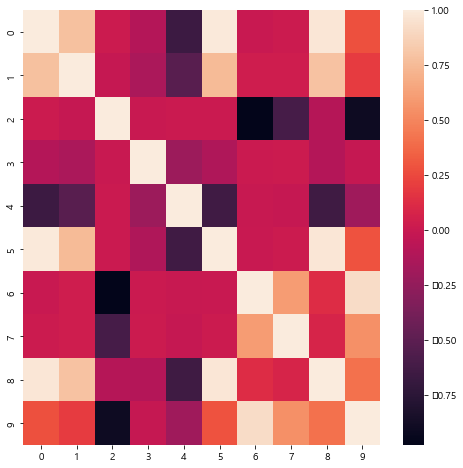

In [143]:
## 다항회귀 selection 한 피처들 간 상관관계가 높아보이는 것들이 은근 많이 있는것을 확인.
import seaborn as sns
plt.figure(figsize = (8,8))
sns.heatmap(pd.DataFrame(X_selcstd_minsu_train).corr())
plt.show()

In [144]:
## PCA 진행 -> 차원축소보다는 이질적인 변수들을 추출하기 위한 목적
pca = PCA(n_components = 10,random_state = 0) 
pca_minsu_train = pca.fit_transform(X_selcstd_minsu_train)
pca_minsu_test = pca.transform(X_selcstd_minsu_test)

-------------------------------------------------

### Modeling

#### LGBM

In [145]:
#여기

In [146]:
lgbm_model = LGBMRegressor(random_state=0)
lgbm_model.fit(pca_minsu_train,y_minsu_train)

C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMRegressor(random_state=0)

10383409984.312304 10383409984.312304


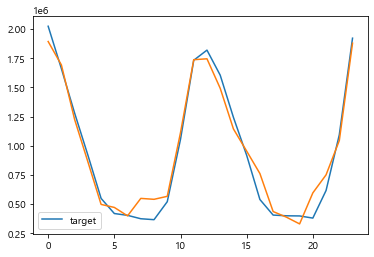

In [147]:
y_minsu_prediction=[]
lgbm_pca_minsu_prediction = lgbm_model.predict(pca_minsu_test)

y_minsu_prediction.append(lgbm_pca_minsu_prediction)
print(mean_squared_error(y_minsu_test,lgbm_pca_minsu_prediction),mean_squared_error(y_minsu_test,lgbm_pca_minsu_prediction))
y_minsu_test.reset_index(drop=True).plot()
plt.plot(lgbm_pca_minsu_prediction)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

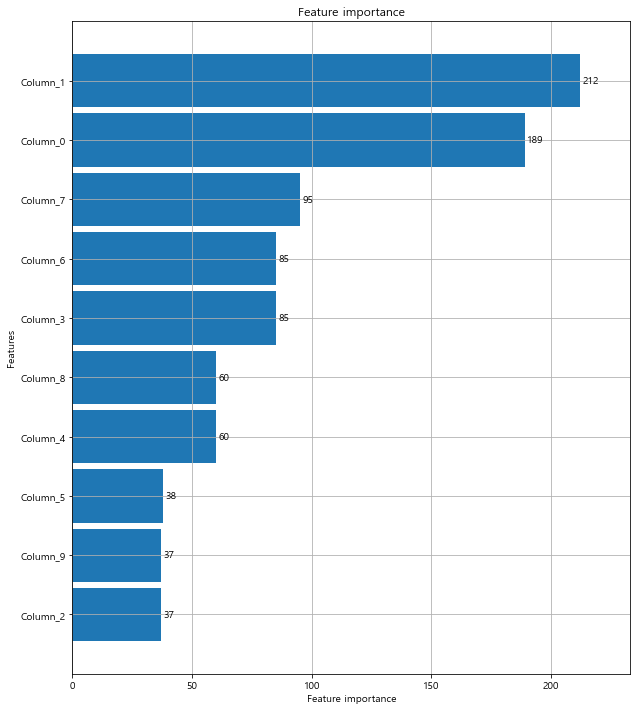

In [148]:
fig, ax = plt.subplots(figsize=(10,12))
lightgbm.plot_importance(lgbm_model,max_num_features=60,height=.9,ax=ax)

##### 다항회귀SELECT+std+poly

In [149]:
#lgbm
lgbm_model = LGBMRegressor(random_state=0)
lgbm_model.fit(X_selcpolystd_minsu_train,y_minsu_train)

C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMRegressor(random_state=0)

6716938187.06507 6716938187.06507


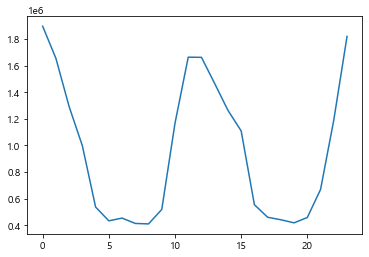

In [150]:
lgbm_selc_minsu_prediction = lgbm_model.predict(X_selcpolystd_minsu_test)
y_minsu_prediction.append(lgbm_selc_minsu_prediction)
print(mean_squared_error(y_minsu_test,lgbm_selc_minsu_prediction),mean_squared_error(y_minsu_test,lgbm_selc_minsu_prediction))
plt.plot(lgbm_selc_minsu_prediction)
plt.show()

-------

**하이퍼 파라미터 튜닝과정인데 실험결과 성능이 좋게 나오지 않아서 최종적으로 튜닝은 사용하지 않음 실행하지 않아도 됨**

In [256]:
# from bayes_opt import BayesianOptimization
# bayesian_params = {
#     'n_estimators' : (50,500),
#     'learning_rate' : (0.0001,0.1),
#     'max_depth' : (1,30),
#     'num_leaves' : (16,50),
#     'min_child_samples' : (50,300),
#     'min_child_weight' : (1,50),
#     'subsample' : (0.5,1),
#     'colsample_bytree' : (0.01,1),
#     'max_bin' : (10,50),
#     'reg_lambda' : (0.001,1),
#     'reg_alpha' : (0.001,1),
#     'feature_fraction' : (0.0001,0.99)
# }

In [257]:
# ## hyper parameter tunning
# def lgb_eval(n_estimators, learning_rate, max_depth ,num_leaves, min_child_samples,min_child_weight,subsample,colsample_bytree,max_bin,reg_lambda,reg_alpha,feature_fraction):
    
#     params = {
#         'n_estimators': int(round(n_estimators)),
#         'learning_rate': learning_rate,
#         'max_depth': int(round(max_depth)),
#         'num_leaves': int(round(num_leaves)),
#         'min_child_samples': int(round(min_child_samples)),
#         'min_child_weight' : int(round(min_child_weight)),
#         'subsample' : max(min(subsample,1),0),
#         'colsample_bytree' : max(min(colsample_bytree,1),0),
#         'reg_lambda' : max(reg_lambda,0),
#         'reg_alpha' : max(reg_alpha,0),
#         'feature_fractoin' : max(feature_fraction,0),
#         'random_state':0,
#         'n_jobs' : -1
#     }

#     lgb_model = LGBMRegressor(**params,objective = 'regression',device ='gpu')
#     lgb_model.fit(X_selcpolystd_minsu_train,y_minsu_train,
#                   eval_set = [(X_selcpolystd_minsu_train,y_minsu_train),(X_selcpolystd_minsu_test,y_minsu_test)],
#                   eval_metric = 'mse', early_stopping_rounds = 100)
#     pred  = lgb_model.predict(X_selcpolystd_minsu_test)
#     score = -1 * mean_squared_error(y_minsu_test,pred)
    
#     return score
    

In [320]:
# lgb_polyBO = BayesianOptimization(f = lgb_eval,pbounds =bayesian_params,random_state = 0)
# lgb_polyBO.maximize(init_points= 5,n_iter = 100)

In [259]:
# selcpoly_params = lgb_polyBO.max['params']
# selcpoly_params['n_estimators'] = int(round(selcpoly_params['n_estimators']))
# selcpoly_params['num_leaves'] = int(round(selcpoly_params['num_leaves']))
# selcpoly_params['max_depth'] = int(round(selcpoly_params['max_depth']))
# selcpoly_params['min_child_samples'] = int(round(selcpoly_params['min_child_samples']))
# selcpoly_params['max_bin'] = int(round(selcpoly_params['max_bin']))

C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LightGBM] [Warning] feature_fraction is set=0.13351593798372666, colsample_bytree=0.03198085747970601 will be ignored. Current value: feature_fraction=0.13351593798372666
13239089194.720993 13239089194.720993


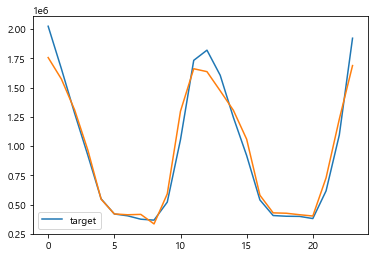

In [260]:
# lgbm_tunning_poly_model = LGBMRegressor(random_state = 0,verbose = -1 , **selcpoly_params ,objective = 'regression')
# lgbm_tunning_poly_model.fit(X_selcpolystd_minsu_train,y_minsu_train)

# tunning_poly_predictions = []
# tunning_poly_prediction = lgbm_tunning_poly_model.predict(X_selcpolystd_minsu_test)
# tunning_poly_predictions.append(tunning_poly_prediction)

# print(mean_squared_error(y_minsu_test,tunning_poly_prediction),mean_squared_error(y_minsu_test,tunning_poly_prediction))
# y_minsu_test.reset_index(drop=True).plot()
# plt.plot(tunning_poly_prediction)
# plt.show()

---------

### 실험내용

- original =>                 6,651,427,245

  sklearn feature selection =>        9,373,323,852
  
  다항회귀 select     =>      13,627,266,303
  
  다항회귀 select + poly   =>  7,437,074,159 
  
  다항회귀 select+poly+std  =>  6,716,938,187
  
  original + poly +std  =>    3,850,176,942
  
  original + poly     =>      3,526,830,888
  
  original_ scaled_ pca                =>       6,475,804,348
  
  다항회귀 select+pca => 10,383,409,984
  
  **튜닝했을 때 성능이 더 안좋게 나옴**
  
결론 : **예측해야하는 시점의 x값을 95개 다 예측할 수 없으므로 최종적으로 성능 비슷하고, 이질적인 피처들이 들어간 다항회귀 feautre selection PCA 와 다항회귀 selectpolystd 데이터셋 2개를 각각 학습한 모델을 가중치 앙상블 하는 것을 사용**

In [ ]:
# 최종 앙상블 mse 값 5,824,200,399

5824200399.446761 5824200399.446761


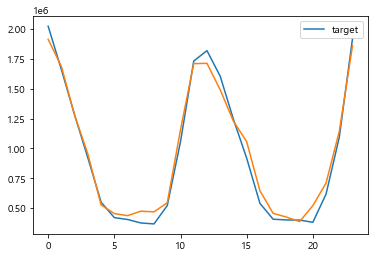

In [151]:
## Ensemble은 pca한거 + selcpolystd  기준 : 다항회귀 Feature Selection 
## selcpolystd 피처 모델링 결과값 0.6 + pca 피처 모델링 결과값 0.41 가중치 앙상블 => 최종 mse값 => 앞으로의 예측에서의 가중치 앙상블 비율은 이와 비슷하게 진행

lgbm_ensem_minsu_prediction = lgbm_pca_minsu_prediction * 0.41 +  lgbm_selc_minsu_prediction  * 0.60
lgbm_selc_minsu_prediction

y_minsu_prediction.append(lgbm_ensem_minsu_prediction)
print(mean_squared_error(y_minsu_test,lgbm_ensem_minsu_prediction),mean_squared_error(y_minsu_test,lgbm_ensem_minsu_prediction))
y_minsu_test.reset_index(drop=True).plot()
plt.plot(lgbm_ensem_minsu_prediction)
plt.show()

-------

### Predict

In [152]:
# D-linear로 예측한 Test 시점의 X값 가져오기 -> train에서는 계, 수도권 기온반응도, cos month를 추가적으로 넣어주어야함.

print(minsu_use_cols)

# new_feature에 D-linear로 예측한 Test 시점의 x값들을 합침.
new_feature = pd.DataFrame(pd.read_csv('target1.csv').date)

new_feature['QVA(제조업부가가치/단위:십억원)'] = pd.read_csv('target1.csv').target
new_feature['GAS_PRICE(산업용도시가스)'] = pd.read_csv('target2.csv').target
new_feature['평균기온(℃)'] = pd.read_csv('target3.csv').target
new_feature['주택용'] = pd.read_csv('target4.csv').target
new_feature['일반용'] = pd.read_csv('target5.csv').target
new_feature['전력'] = pd.read_csv('target6.csv').target
new_feature['열'] = pd.read_csv('target7.csv').target
new_feature['난방도일 (도일)'] = pd.read_csv('target8.csv').target
new_feature['전기업'] = pd.read_csv('target9.csv').target
new_feature['수도권 기온효과'] = pd.read_csv('target10.csv').target

['QVA(제조업부가가치/단위:십억원)', 'GAS_PRICE(산업용도시가스)', '평균기온(℃)', '주택용', '일반용', '계', '수도권 기온반응도', 'cos_month', '전력', '열']


In [153]:
# new feature를 민수용 산업용(민수+산업용)에 맞게 추가

new_feature['date'] = pd.to_datetime(new_feature.date)
new_feature['month'] = new_feature.date.dt.month
new_feature['cos_month'] = np.cos(2 * np.pi * new_feature['month']/11.0)

new_feature['기온'] = new_feature["평균기온(℃)"].apply(lambda x : round(x,1))
new_feature = pd.merge(new_feature,baneung[['기온','수도권 기온반응도']],how ='left', on = '기온');new_feature

pop['yearmonth'] = pop.date.dt.year.astype(str) + pop.date.dt.month.astype(str)
new_feature['yearmonth'] = new_feature.date.dt.year.astype(str) + new_feature.month.astype(str)
new_feature = pd.merge(new_feature,pop[['yearmonth','계']],how = 'left', on ='yearmonth');new_feature

##### 
# 사용할 피처만 추림. 안쓰는 피처들을 뺌.
new_feature.drop(columns = ['month','기온','yearmonth'],inplace = True );new_feature

,date,QVA(제조업부가가치/단위:십억원),GAS_PRICE(산업용도시가스),평균기온(℃),주택용,일반용,전력,열,난방도일 (도일),전기업,수도권 기온효과,cos_month,수도권 기온반응도,계
0,1998-01-31,38451.292222,39.860000,-1.300000,10.081096,8.410411,1359.000000,149.000000,600.100000,2643.933333,0.808120,0.841254,0.18121,4.598132e+07
1,1998-02-28,37453.884444,45.300000,3.400000,9.962192,8.520822,1326.000000,133.000000,410.200000,2697.666667,0.646960,0.415415,0.09016,4.600907e+07
2,1998-03-31,36553.000000,45.300000,7.300000,9.854795,8.620548,1344.000000,104.000000,330.800000,2746.200000,0.434590,-0.142315,0.02069,4.603681e+07
3,1998-04-30,36277.841304,45.300000,15.600000,9.735890,8.730959,1351.000000,72.000000,87.800000,2767.765217,-0.186940,-0.654861,-0.07546,4.606455e+07
4,1998-05-31,36011.558696,45.300000,19.000000,9.620822,8.837808,1344.000000,45.000000,17.600000,2788.634783,-0.441760,-0.959493,-0.09651,4.609230e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,2034-08-31,177572.812500,86.994644,25.295259,10.346368,2.224779,5517.043945,-44.261227,-26.440195,9618.652344,-0.451088,-0.142315,-0.13634,5.097144e+07
440,2034-09-30,178437.125000,86.980721,20.768566,10.340062,2.222959,5216.731445,-24.536236,24.374090,9706.775391,-0.289504,0.415415,-0.10618,5.096555e+07
441,2034-10-31,178954.109375,86.272064,14.174806,10.333147,2.217233,4677.029785,114.202187,155.903091,9733.354492,-0.046707,0.841254,-0.06442,5.095965e+07
442,2034-11-30,178814.906250,86.747322,7.068441,10.330956,2.223823,4626.931641,357.236572,339.241516,9700.044922,0.207983,1.000000,0.02394,5.095375e+07


#### 민수용 Prediction

In [154]:
# 민수용과 산업용(민수+산업)으로 나눔
new_minsu_feature = new_feature.loc[276:,minsu_use_cols] # 예측 시점의 select된 피처의 값들만 사용.
new_sanup_feature = new_feature.loc[276:,sanup_use_cols] # 예측 시점의 select된 피처의 값들만 사용.

# 예측할 때는 전체기간을 학습데이터로 사용함.
total_minsu_train = X_minsu[minsu_use_cols]
total_sanup_train = X_sanup[sanup_use_cols]
y_total = pd.concat([y_minsu_train,y_minsu_test],axis = 0)

In [156]:
## Polynomial Features 생성
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2,include_bias = True)

X_poly_minsu_train = poly_features.fit_transform(total_minsu_train)
X_poly_minsu_test = poly_features.transform(new_minsu_feature)


In [157]:
## 위와 똑같이 스케일링 진행
scaler = StandardScaler()

X_polystd_minsu_train = scaler.fit_transform(X_poly_minsu_train)
X_polystd_minsu_test = scaler.transform(X_poly_minsu_test)

X_std_minsu_train = scaler.fit_transform(total_minsu_train)
X_std_minsu_test = scaler.transform(new_minsu_feature)

In [158]:
## PCA 진행
pca = PCA(n_components = 10,random_state = 0) # PCA를 차원을 줄이는 목적이 아닌 새로운 값을 찾아내기 위해서 진행.
X_pca_minsu_train = pca.fit_transform(X_std_minsu_train)
X_pca_minsu_test = pca.transform(X_std_minsu_test)

In [159]:
# 전체 train_data로 학습 및 예측

lgbm_pca_model = LGBMRegressor(random_state = 0)
lgbm_poly_model = LGBMRegressor(random_state = 0)

lgbm_pca_model.fit(X_pca_minsu_train,y_total)
lgbm_poly_model.fit(X_polystd_minsu_train,y_total)

lgbm_pca_minsu_prediction = lgbm_pca_model.predict(X_pca_minsu_test)
lgbm_poly_minsu_prediction = lgbm_poly_model.predict(X_polystd_minsu_test)

C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [168]:
# 각각의 데이터셋을 가중치 앙상블 진행 pca 결과값 0.3, poly 결과값 0.7로 줌.
final_lgbm_minsu_prediction = lgbm_pca_minsu_prediction * 0.3 +  lgbm_poly_minsu_prediction  * 0.7 

#### 산업용(민수+산업용 즉,Total) Predict

In [161]:
## Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2,include_bias = True)

X_poly_sanup_train = poly_features.fit_transform(total_sanup_train)
X_poly_sanup_test = poly_features.transform(new_sanup_feature)


In [162]:
scaler = StandardScaler()

X_polystd_sanup_train = scaler.fit_transform(X_poly_sanup_train)
X_polystd_sanup_test = scaler.transform(X_poly_sanup_test)

X_std_sanup_train = scaler.fit_transform(total_sanup_train)
X_std_sanup_test = scaler.transform(new_sanup_feature)

In [163]:
## PCA 진행
pca = PCA(n_components = 10,random_state = 0) # PCA를 차원을 줄이는 목적이 아닌 새로운 값을 찾아내기 위해서 진행.
X_pca_sanup_train = pca.fit_transform(X_std_sanup_train)
X_pca_sanup_test = pca.transform(X_std_sanup_test)

In [164]:
# 전체 train_data로 학습 및 예측

y_total = pd.concat([y_sanup_train,y_sanup_test],axis = 0)

lgbm_pca_sanup_model = LGBMRegressor(random_state = 0)
lgbm_poly_sanup_model = LGBMRegressor(random_state = 0)

lgbm_pca_sanup_model.fit(X_pca_sanup_train,y_total)
lgbm_poly_sanup_model.fit(X_polystd_sanup_train,y_total)

lgbm_pca_sanup_prediction = lgbm_pca_sanup_model.predict(X_pca_sanup_test)
lgbm_poly_sanup_prediction = lgbm_poly_sanup_model.predict(X_polystd_sanup_test)

C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


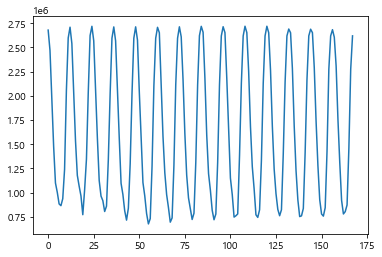

In [165]:
# 위 민수용 과정과 동일
final_lgbm_sanup_prediction = lgbm_pca_sanup_prediction * 0.3 +  lgbm_poly_sanup_prediction  * 0.7
plt.plot(final_lgbm_sanup_prediction)

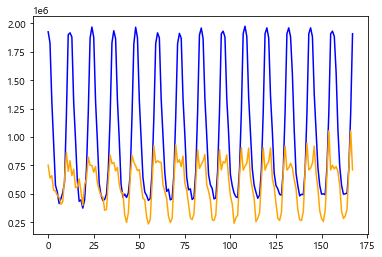

In [172]:
# real_sanup = total(민수용 + 산업용) - 민수용

real_sanup_prediction = final_lgbm_sanup_prediction - final_lgbm_minsu_prediction

plt.plot(final_lgbm_minsu_prediction,c ='b')
plt.plot(real_sanup_prediction,c= 'orange')
plt.show()

-----------------------------

## Extra Tree로 Modeling

##### 민수용 Predict

In [173]:
X_pca_minsu_train
X_polystd_minsu_train
y_total = pd.concat([y_minsu_train,y_minsu_test],axis = 0)

C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\1692504763.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_pca_model.fit(X_pca_minsu_train,y_total)
C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\1692504763.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_poly_model.fit(X_polystd_minsu_train,y_total)


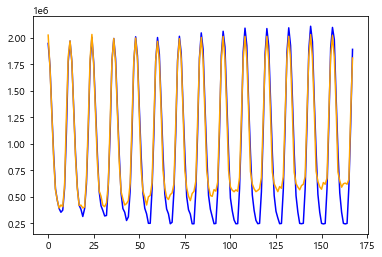

In [174]:
from sklearn.ensemble import ExtraTreesRegressor

extra_pca_model = ExtraTreesRegressor(random_state = 0)
extra_pca_model.fit(X_pca_minsu_train,y_total)

extra_poly_model = ExtraTreesRegressor(random_state = 0)
extra_poly_model.fit(X_polystd_minsu_train,y_total)

extra_pca_prediction = extra_pca_model.predict(X_pca_minsu_test)
extra_poly_prediction = extra_poly_model.predict(X_polystd_minsu_test)

plt.plot(extra_poly_prediction,c= 'b')
plt.plot(extra_pca_prediction,c='orange')
plt.show()

##### 산업용(민수용+산업용 즉, Total) Predict

C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\4138679032.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_pca_sanup_model.fit(X_pca_sanup_train,y_total)
C:\Users\kogas\AppData\Local\Temp\3\ipykernel_10064\4138679032.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_poly_sanup_model.fit(X_polystd_sanup_train,y_total)


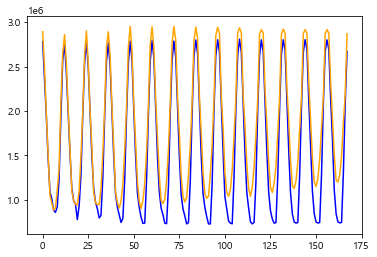

In [175]:
# 산업용
from sklearn.ensemble import ExtraTreesRegressor

y_total = pd.concat([y_sanup_train,y_sanup_test],axis = 0)

extra_pca_sanup_model = ExtraTreesRegressor(random_state = 0)
extra_pca_sanup_model.fit(X_pca_sanup_train,y_total)

extra_poly_sanup_model = ExtraTreesRegressor(random_state = 0)
extra_poly_sanup_model.fit(X_polystd_sanup_train,y_total)

extra_pca_sanup_prediction = extra_pca_sanup_model.predict(X_pca_sanup_test)
extra_poly_sanup_prediction = extra_poly_sanup_model.predict(X_polystd_sanup_test)

plt.plot(extra_poly_sanup_prediction,c= 'b')
plt.plot(extra_pca_sanup_prediction,c='orange')
plt.show()

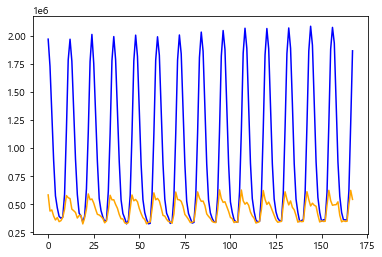

In [177]:
final_minsu_extra_prediction = extra_poly_prediction * 0.7 + extra_pca_prediction * 0.3
final_total_extra_prediction = extra_poly_sanup_prediction * 0.7 + extra_pca_prediction * 0.3

# 총합(민수+산업) - 산업용
real_sanup_extra_prediction = final_total_extra_prediction - final_minsu_extra_prediction # 실제 산업값

# 최종 예측 그래프
plt.plot(final_minsu_extra_prediction,c= 'b')
plt.plot(real_sanup_extra_prediction,c='orange')
plt.show()

------

### 다항회귀 적합 -> Statsmodels 사용

In [178]:
# 따로 poly와 pca과정으로 feature engineering 과정을 진행하지 않은 것으로 진행 
## 피처는 위에서 다항회귀식 feature selection으로 진행
total_minsu_train = X_minsu[minsu_use_cols]
total_sanup_train = X_sanup[sanup_use_cols]

##### 민수용 다항회귀 predict

In [179]:
# 민수용 다항회귀 
import statsmodels.formula.api as smf

total_minsu_train = X_minsu[minsu_use_cols]
y_minsu_total = pd.concat([y_minsu_train,y_minsu_test],axis = 0)

dahang_minsu_train = pd.concat([total_minsu_train,y_minsu_total],axis = 1)

num = 0
for i in total_minsu_train.columns:
    dahang_minsu_train.rename(columns = {f'{i}':f"a{num}"},inplace = True)
    num+=1

column = ''
for i in dahang_minsu_train.columns[:-1]:
    if column == 'a9':
        column += i
    else:
        column += i + '+'
    
dahang_minsu_model = smf.ols(f'target ~ {column[:-1]}',data = dahang_minsu_train).fit()
dahang_minsu_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2742.
Date:                Fri, 25 Nov 2022   Prob (F-statistic):          4.00e-261
Time:                        04:48:01   Log-Likelihood:                -3390.9
No. Observations:                 276   AIC:                             6804.
Df Residuals:                     265   BIC:                             6844.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.778e+06   7.13e+05      6.697      0.000    3.37e+06    6.18e+06
a0            -2.3748      1.260     -1.885      0.060      -4.855       0.105
a1           388.5451    248.203      1.565      0.119    -100.156     877.246
a2         -1.362e+04   1943.620     -7.006      0.000   -1.74e+04   -9789.663
a3         -6090.1684   3709.753     -1.642      0.102   -1.34e+04    1214.173
a4         -2.733e+04   2975.664     -9.185      0.000   -3.32e+04   -2.15e+04
a5            -0.0948      0.016     -5.888      0.000      -0.126      -0.063
a6          9.988e+05   1.62e+05      6.161      0.000     6.8e+05    1.32e+06
a7         -3.638e+04   5728.637     -6.350      0.000   -4.77e+04   -2.51e+04
a8           314.6177     31.513      9.984      0.000     252.569     376.666
a9          2187.9552    110.421     19.815      0.000    1970.541    2405.370
==============================================================================
Omnibus:                        6.962   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.150
Skew:                           0.299   Prob(JB):                       0.0280
Kurtosis:                       3.514   Cond. No.                     1.09e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [180]:
#민수용 예측

num = 0
for i in new_minsu_feature.columns:
    new_minsu_feature.rename(columns = {f'{i}':f"a{num}"},inplace = True)
    num+=1
dahang_minsu_predict = dahang_minsu_model.predict(new_minsu_feature)

##### 산업용 (민수 + 산업용 ,즉 total) 예측

In [181]:
# 민수 + 산업 다항회귀

import statsmodels.formula.api as smf

total_sanup_train = X_sanup[sanup_use_cols]
y_sanup_total = pd.concat([y_sanup_train,y_sanup_test],axis = 0)

dahang_sanup_train = pd.concat([total_sanup_train,y_sanup_total],axis = 1)

num = 0
for i in total_sanup_train.columns:
    dahang_sanup_train.rename(columns = {f'{i}':f"a{num}"},inplace = True)
    num+=1
    
dahang_sanup_model = smf.ols(f'target ~ {column[:-1]}',data = dahang_sanup_train).fit()
dahang_sanup_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2427.
Date:                Fri, 25 Nov 2022   Prob (F-statistic):          3.59e-254
Time:                        04:48:03   Log-Likelihood:                -3468.3
No. Observations:                 276   AIC:                             6959.
Df Residuals:                     265   BIC:                             6998.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.416e+06   9.44e+05      3.617      0.000    1.56e+06    5.28e+06
a0             0.9195      1.668      0.551      0.582      -2.364       4.203
a1          3711.5108    328.607     11.295      0.000    3064.498    4358.524
a2         -1.324e+04   2573.247     -5.147      0.000   -1.83e+04   -8178.325
a3          4390.3178   4911.510      0.894      0.372   -5280.231    1.41e+04
a4          -2.19e+04   3939.617     -5.559      0.000   -2.97e+04   -1.41e+04
a5            -0.0719      0.021     -3.374      0.001      -0.114      -0.030
a6          9.922e+05   2.15e+05      4.622      0.000     5.7e+05    1.41e+06
a7         -5536.1250   7584.402     -0.730      0.466   -2.05e+04    9397.232
a8           287.3797     41.722      6.888      0.000     205.231     369.528
a9          2737.7060    146.192     18.727      0.000    2449.861    3025.551
==============================================================================
Omnibus:                        9.017   Durbin-Watson:                   1.138
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               15.083
Skew:                          -0.142   Prob(JB):                     0.000531
Kurtosis:                       4.110   Cond. No.                     1.09e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [182]:
#민수+산업용 예측 결과값
num = 0
for i in new_sanup_feature.columns:
    new_sanup_feature.rename(columns = {f'{i}':f"a{num}"},inplace = True)
    num+=1
dahang_sanup_predict = dahang_sanup_model.predict(new_sanup_feature)

## 총합 - 민수용 = 산업용
real_dahang_sanup_predict = dahang_sanup_predict - dahang_minsu_predict

[]

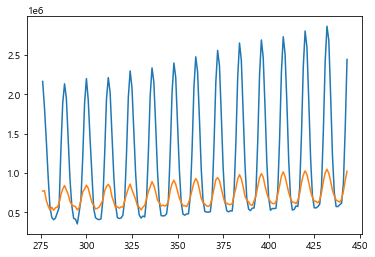

In [183]:
plt.plot(dahang_minsu_predict)
plt.plot(real_dahang_sanup_predict)
plt.plot()

------

## 최종 Submission 제출용 생성

**실험적으로 진행해보았을 떄 lgbm보다 extra tree와 다항회귀 예측값들의 그래프가 보다 유사하게 나왔기 때문에 extra tree와 다항회귀 예측값을 gmean하고, 위에서 target값 예측한 y_pred 값과 가중평균하여 최종 submission 제출**

In [184]:
# extra_tree 와 다항회귀 gmean 진행
from scipy.stats import gmean

gmean_minsu_prediction = gmean([dahang_minsu_predict,final_minsu_extra_prediction],axis = 0)
gmean_sanup_prediction = gmean([real_dahang_sanup_predict,real_sanup_extra_prediction],axis = 0)

In [596]:
# 가중치 0.8을 y_pred , 가중치 0.2을 머신러닝 모델 주고 진행.
y_pred = pd.read_csv('1266_submission.csv')

y_pred['CIVIL'] = (gmean_minsu_prediction) * 0.2 + y_pred.CIVIL * 0.8
y_pred['IND'] = (gmean_sanup_prediction) * 0.1 + y_pred.IND * 0.9

y_pred.iloc[:,1:].to_csv('extra_dahang_gmean_y_ensemble1.csv', index = False)

----Finish----